In this notebook, we will look at the necessary steps required before any machine learning takes place.
* load the data
* look at the variables in the dataset, in particular, differentiate
  between numerical and categorical variables, which need different
  preprocessing in most machine learning workflows
* visualize the distribution of the variables to gain some insights into the dataset

In [ ]:
# Inline plots
%matplotlib inline

# plotting style
import seaborn as sns

## Loading the adult census dataset

We will use data from the "Current Population adult_census" from 1994 that we
downloaded from [OpenML](http://openml.org/).

In [2]:
import pandas as pd

adult_census = pd.read_csv(
    "https://www.openml.org/data/get_csv/1595261/adult-census.csv")

# Or use the local copy:
# adult_census = pd.read_csv('../datasets/adult-census.csv')

We can look at the OpenML webpage to know more about this dataset.

In [ ]:
from IPython.display import IFrame
IFrame('https://www.openml.org/d/1590', width=1200, height=600)

## Look at the variables in the dataset
The data are stored in a pandas dataframe.

In [ ]:
adult_census.head()

The column named **class** is our target variable (i.e., the variable which
we want to predict). The two possible classes are `<= 50K` (low-revenue) and
`> 50K` (high-revenue).

In [3]:
target_column = 'class'
adult_census[target_column].value_counts()

 <=50K    37155
 >50K     11687
Name: class, dtype: int64

Note: classes are slightly imbalanced. Class imbalance happens often in
practice and may need special techniques for machine learning. For example in
a medical setting, if we are trying to predict whether patients will develop
a rare disease, there will be a lot more healthy patients than ill patients in
the dataset.

The dataset contains both numerical and categorical data. Numerical values
can take continuous values for example `age`. Categorical values can have a
finite number of values, for example `native-country`.

In [4]:
numerical_columns = [
    'age', 'education-num', 'capital-gain', 'capital-loss',
    'hours-per-week']
categorical_columns = [
    'workclass', 'education', 'marital-status', 'occupation',
    'relationship', 'race', 'sex', 'native-country']
all_columns = numerical_columns + categorical_columns + [
    target_column]

adult_census = adult_census[all_columns]

Note that for simplicity, we have ignored the "fnlwgt" (final weight) column
that was crafted by the creators of the dataset when sampling the dataset to
be representative of the full census database.

## Inspect the data
Before building a machine learning model, it is a good idea to look at the
data:
* maybe the task you are trying to achieve can be solved without machine
  learning
* you need to check that the data you need for your task is indeed present in
the dataset
* inspecting the data is a good way to find peculiarities. These can can
  arise during data collection (for example, malfunctioning sensor or missing
  values), or from the way the data is processed afterwards (for example capped
  values).

Let's look at the distribution of individual variables, to get some insights
about the data. We can start by plotting histograms, note that this only
works for numerical variables:

In [ ]:
_ = adult_census.hist(figsize=(20, 10))

We can already make a few comments about some of the variables:
* age: there are not that many points for 'age > 70'. The dataset description
does indicate that retired people have been filtered out (`hours-per-week > 0`).
* education-num: peak at 10 and 13, hard to tell what it corresponds to
without looking much further. We'll do that later in this notebook.
* hours per week peaks at 40, this was very likely the standard number of
working hours at the time of the data collection
* most values of capital-gain and capital-loss are close to zero

For categorical variables, we can look at the distribution of values:

In [ ]:
adult_census['sex'].value_counts()

In [ ]:
adult_census['education'].value_counts()

`pandas_profiling` is a nice tool for inspecting the data (both numerical and
categorical variables).

In [ ]:
import pandas_profiling
adult_census.profile_report()

As noted above, `education-num` distribution has two clear peaks around 10
and 13. It would be reasonable to expect that `education-num` is the number of
years of education. Let's look at the relationship between `education` and
`education-num`.

In [ ]:
pd.crosstab(index=adult_census['education'],
            columns=adult_census['education-num'])

This shows that education and education-num gives you the same information.
For example, `education-num=2` is equivalent to `education='1st-4th'`. In
practice that means we can remove `education-num` without losing information.
Note that having redundant (or highly correlated) columns can be a problem
for machine learning algorithms.

Another way to inspect the data is to do a pairplot and show how each variable
differs according to our target, `class`. Plots along the diagonal show the
distribution of individual variables for each `class`. The plots on the
off-diagonal can reveal interesting interactions between variables.

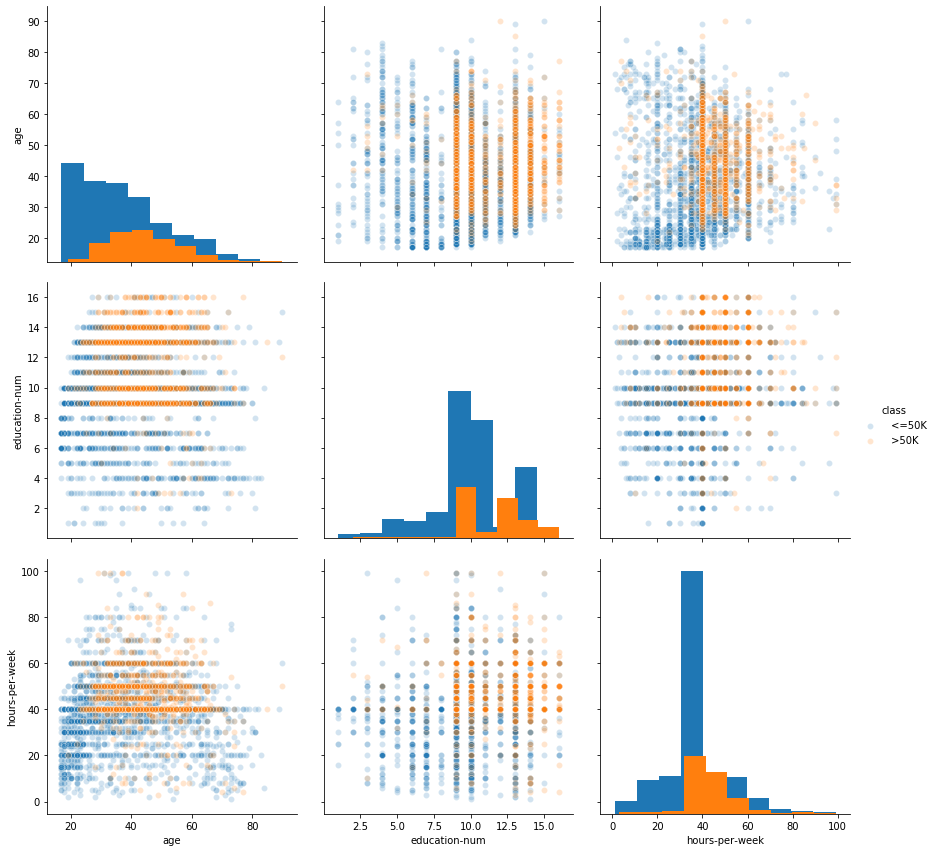

In [5]:
n_samples_to_plot = 5000
columns = ['age', 'education-num', 'hours-per-week']
_ = sns.pairplot(data=adult_census[:n_samples_to_plot], vars=columns,
                 hue=target_column, plot_kws={'alpha': 0.2},
                 height=4, diag_kind='hist')

In [ ]:
_ = sns.pairplot(data=adult_census[:n_samples_to_plot], x_vars='age',
                 y_vars='hours-per-week', hue=target_column,
                 markers=['o',
                          'v'], plot_kws={'alpha': 0.2}, height=12)


By looking at the data you could infer some hand-written rules to predict the
class:
* if you are young (less than 25 year-old roughly), you are in the `<= 50K` class.
* if you are old (more than 70 year-old roughly), you are in the `<= 50K` class.
* if you work part-time (less than 40 hours roughly) you are in the `<= 50K` class.

These hand-written rules could work reasonably well without the need for any
machine learning. Note however that it is not very easy to create rules for
the region `40 < hours-per-week < 60` and `30 < age < 70`. We can hope that
machine learning can help in this region. Also note that visualization can
help creating hand-written rules but is limited to 2 dimensions (maybe 3
dimensions), whereas machine learning models can build models in
high-dimensional spaces.

Another thing worth mentioning in this plot: if you are young (less than 25
year-old roughly) or old (more than 70 year-old roughly) you tend to work
less. This is a non-linear relationship between age and hours
per week. Some machine learning models can only capture linear interactions so
this may be a factor when deciding which model to chose.

In a machine-learning setting, we will use an algorithm to automatically
decide what should be the "rules" in order to make predictions on new data.
We can check which set of simple rules a decision tree would grasp using the
same data.

In [77]:
def plot_tree_decision_function(tree, X, y, ax):
    """Plot the different decision rules found by a `DecisionTreeClassifier`.

    Parameters
    ----------
    tree : DecisionTreeClassifier instance
        The decision tree to inspect.
    X : dataframe of shape (n_samples, n_features)
        The data used to train the `tree` estimator.
    y : ndarray of shape (n_samples,)
        The target used to train the `tree` estimator.
    ax : matplotlib axis
        The matplotlib axis where to plot the different decision rules.
    """
    import numpy as np
    from scipy import ndimage

    h = 0.02
    x_min, x_max = 0, 100
    y_min, y_max = 0, 100
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = tree.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    faces = tree.tree_.apply(
        np.c_[xx.ravel(), yy.ravel()].astype(np.float32))
    faces = faces.reshape(xx.shape)
    border = ndimage.laplace(faces) != 0
    ax.scatter(X.iloc[:, 0], X.iloc[:, 1],
               c=np.array(['tab:blue',
                           'tab:red'])[y], s=60, alpha=0.7)
    cs = ax.contourf(xx, yy, Z, alpha=.4, cmap='RdBu_r', vmin=0, vmax=1)
    cb = ax.get_figure().colorbar(cs)
    # cb.set_(0, 1)
    ax.scatter(xx[border], yy[border], marker='.', s=1)
    ax.set_xlabel(X.columns[0])
    ax.set_ylabel(X.columns[1])
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    sns.despine(offset=10)


In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update(mpl.rcParamsDefault)  # reset the plotting style

In [3]:
from sklearn.preprocessing import LabelEncoder

n_samples_to_plot = 5000
target_column = 'class'
# select a subset of data
data_subset = adult_census[:n_samples_to_plot]
X = data_subset[["age", "hours-per-week"]]
y = LabelEncoder().fit_transform(
    data_subset[target_column].to_numpy())

We will create a decision tree which we will keep really simple on purpose.
We will only allow a maximum of 2 rules to interpret the results.

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

max_leaf_nodes = 3
tree = DecisionTreeClassifier(max_leaf_nodes=max_leaf_nodes,
                              random_state=0)
tree.fit(X, y)
tree.predict_proba([[45, 25]])

array([[0.77051229, 0.22948771]])

We can now check the set of rules learnt by the tree then visually check
what theses rules look like.

[Text(133.92000000000002, 181.2, 'X[0] <= 28.5\nentropy = 0.491\nsamples = 5000\nvalue = [3828, 2930]'),
 Text(66.96000000000001, 108.72, 'entropy = 0.153\nsamples = 1390\nvalue = [1341.0, 122.5]'),
 Text(200.88000000000002, 108.72, 'X[1] <= 40.5\nentropy = 0.498\nsamples = 3610\nvalue = [2487.0, 2807.5]'),
 Text(133.92000000000002, 36.23999999999998, 'entropy = 0.489\nsamples = 2401\nvalue = [1850.0, 1377.5]'),
 Text(267.84000000000003, 36.23999999999998, 'entropy = 0.426\nsamples = 1209\nvalue = [637, 1430]')]

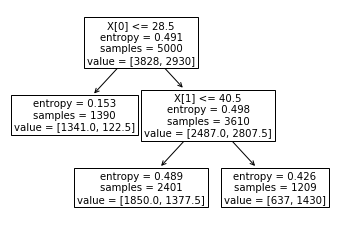

In [9]:
# plot the tree structure
fig, ax = plt.subplots()
plot_tree(tree, ax=ax)

In [5]:
# plot the decision function learned by the tree
fig, ax = plt.subplots()
plot_tree_decision_function(tree, X, y, ax=ax)

NameError: name 'plt' is not defined

In [6]:
import matplotlib.pyplot as plt



import numpy as np
from scipy import ndimage


h = 0.02
x_min, x_max = 0, 100
y_min, y_max = 0, 100
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

Z = tree.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)
faces = tree.tree_.apply(
        np.c_[xx.ravel(), yy.ravel()].astype(np.float32))
faces = faces.reshape(xx.shape)
border = ndimage.laplace(faces) != 0

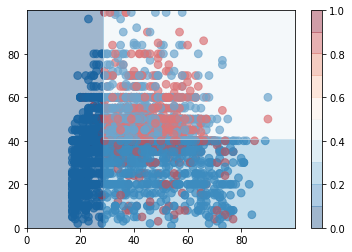

In [7]:
fig, ax = plt.subplots()
ax.scatter(X.iloc[:, 0], X.iloc[:, 1],
               c=np.array(['tab:blue',
                           'tab:red'])[y], s=60, alpha=0.7)
levels = np.linspace(0, 1, 11)
cs = ax.contourf(xx, yy, Z, levels=levels, alpha=0.4, cmap='RdBu_r')
cb = fig.colorbar(cs, ax=ax) 

In [8]:
tree.predict_proba([[60, 60]])

array([[0.52688172, 0.47311828]])

In [ ]:
ax.scatter(xx[border], yy[border], marker='.', s=1)
ax.set_xlabel(X.columns[0])
ax.set_ylabel(X.columns[1])
ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])
sns.despine(offset=10)

In [69]:
from matplotlib.colors import Normalize
n = Normalize(vmin=0, vmax=1, clip=False)
n(-5)

-5.0

In [50]:
cb.norm(-10)

-10.0

In [45]:
cs.get_clim()

(0, 1)

In [7]:
tree.predict_proba([[60, 60]])


array([[0.3081761, 0.6918239]])

In [9]:
cm.ScalarMappable(cmap='RdBu_r')

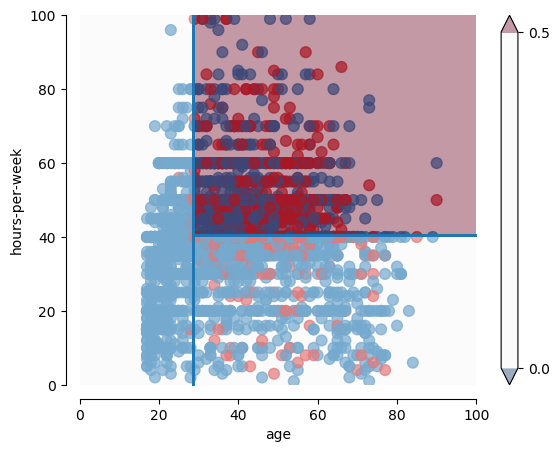

In [11]:
fig

In [32]:
cs = ax.contourf(xx, yy, Z, alpha=.4, cmap='RdBu_r', vmin=0, vmax=1)
cs.get_clim()

(0, 1)

In [26]:
cb.set_clim(0, 1)

/home/lesteve/miniconda3/envs/scikit-learn-tutorial/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.
  """Entry point for launching an IPython kernel.


In [20]:
# plt.cm.get_cmap('RdBu_r',              vmin=0, vmax=1)

cm = plt.cm.RdBu_r
cm.set_clim(0, 1)

AttributeError: 'LinearSegmentedColormap' object has no attribute 'set_clim'

/home/lesteve/miniconda3/envs/scikit-learn-tutorial/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The set_norm function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_norm instead.
  """Entry point for launching an IPython kernel.


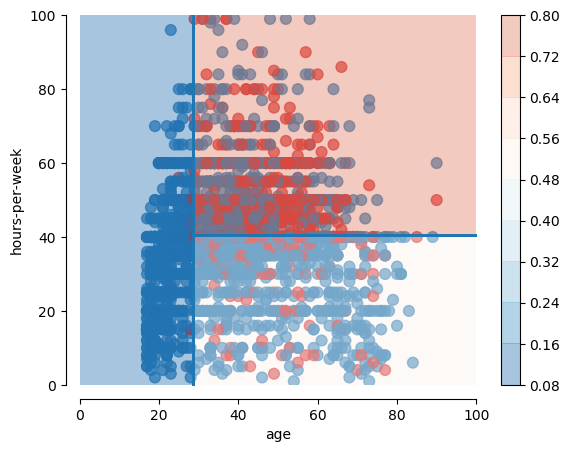

In [93]:
cb = 

In [ ]:
target_column

In [71]:
lb = LabelEncoder()
lb.fit_transform(
    data_subset[target_column].to_numpy())

array([0, 0, 1, ..., 0, 1, 1])

In [72]:
lb.classes_


array([' <=50K', ' >50K'], dtype=object)

In [81]:
tree.predict_proba([[60, 50]])

array([[0.2542637, 0.7457363]])

In [48]:
fig.colorbar?

Allowing only 3 leaves in the tree, we get similar rules to the ones we
designed by hand:
* the persons younger than 28.5 year-old will be considered in the class
  earning `<= 50K`.
* the persons older than 28.5 and working more than 40.5 hours-per-week
  will be considered in the class earning `> 50K`, while the persons working
  below 40.5 hours-per-week, will be considered in the class
  earning `<= 50K`.


In this notebook we have:
* loaded the data from a CSV file using `pandas`
* looked at the kind of variables in the dataset, and differentiated
  between categorical and numerical variables
* inspected the data with `pandas`, `seaborn` and `pandas_profiling`. Data inspection
  can allow you to decide whether using machine learning is appropriate for
  your data and to highlight potential peculiarities in your data

Key ideas discussed:
* if your target variable is imbalanced (e.g., you have more samples from one
  target category than another), you may need special techniques for machine
  learning
* having redundant (or highly correlated) columns can be a problem for
  machine learning algorithms
* some machine learning models can only capture linear interaction so be
  aware of non-linear relationships in your data